# Basic metastudy code

This is a writeup of a basic analysis of a slice of data from [*"Metastudies for robust tests of theory."* by Baribault et al.](https://doi.org/10.1073/pnas.1708285114)

The experimental task consisted of subjects, over multiple sessions, clicking an indicated target either *quickly* or *accurately*, depending on which cue they recieved. The cues were either *visible* or *masked*. Performance at this task nominally reveals whether the value of the *masked cue*, while not consciously perceptible, impacted participant behavior.

The analytic objective is to:
- assess the effect size of cue condition (visibility x instruction)
- for each *experimental session*, use linear regression to find the intercepts and coefficients for the Instruction variable in each visibility condition
- repeat these regressions with an additional penalty term to bias these estimates towards the grand mean of their values across all sessions.


This notebook performs these steps in Python 3.7.x, making use of Pandas, Statsmodels, and Scipy, with Seaborn for plotting.

Generally, only Response Time data is illustrated, although the process is identical for Accuracy.

A possibly more efficient alternative is explored briefly at the end.

In [2]:
#import packages used in this analysis
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats, optimize
import statsmodels.formula.api as sm
from typing import Callable

import warnings
warnings.filterwarnings('ignore')

## Data preparation

In [ ]:
#Data is imported into a 'dataframe' object using the pandas read_csv function
data_master = pd.read_csv("rr.csv")

### Censoring
Invalid subject responses are filtered, following the criteria from the original paper's planned analysis here: https://osf.io/3mqha/  

- response times outside .15 and 2.5
- clicks registered at the (0,0) point on the target screen.
- experimental phase not equal to 1

The following criterion from the original MATLAB code is not implemented, because I'm not sure what it's testing for.
- rand(size(rd.rt)) > 1


In [5]:
#Rows matching censor criteria are selected by index, and dropped from the dataframe.
data_censored = data_master.drop(
    data_master[(data_master.rt < .15) | (data_master.rt > 2.5) | ((data_master.respX == 0) & (data_master.respY == 0)) | (data_master.phase != 1)].index)


One additional filter is applied, to remove sessions in which censoring eliminated all observations from one or more conditions. This is merely a convenience, as it makes implementing certain functions a little easier later on. This censors 27 'sessions', removing a total of 209 out of 151,783 observations.

In [606]:
#remove any groups having zero observations from one or more conditions.
data_censored2 = data_censored
censor_groups = data_censored.groupby(['subj','blk'])

for name, group in censor_groups:
    #print(name, group)
    if len(group.cond.unique()) < 4:
        data_censored2 = data_censored2.drop(censor_groups.get_group(name).index)

print(data_censored.shape[0] - data_censored2.shape[0], "observations removed")

209 observations removed


### Tidying presentation

The dataframe is pruned down to only those variables needed for the analysis. Because the 'experimental sessions' to be analyzed are defined by unique combinations of subject and block, 'subj' and 'blk' columns are retained along with experimental and response variables. 

To make sanity-checking easier, rows are labeled with an English condition description.

In [660]:
#Create a new dataframe, 'df', consisting of a subset of our censored data.
df = data_censored2[['subj','cond_spdAcc','cond_mask','acc','rt','cond','blk']]

#Create a column that labels each row's condition.

conditions = [
    (df['cond'] == 1),
    (df['cond'] == 2),
    (df['cond'] == 3),
    (df['cond'] == 4),]

choices = ['speed_masked','accuracy_masked','speed_visible','accuracy_visible']

df['cond_name'] = np.select(conditions, choices)

### Making dummy variables
It will become convenient later to create dummy variables for each condition. This is done using pandas' convenience function get_dummies on the "cond" variable, and by subtracting 1 from the 1-indexed "cond_spdAcc" and "cond_mask" variables.

In [608]:
#generate and concatenate a dummy variable matrix from the cond column
dummy_columns = pd.get_dummies(df['cond'])
df = pd.concat([df,dummy_columns],axis=1)

#Convert Cue/Mask condition column values from one-index to zero-index
df['cond_spdAcc'] = df['cond_spdAcc'] - 1
df['cond_mask'] = df['cond_mask'] - 1 

print(df.head(2))

   subj  cond_spdAcc  cond_mask      acc       rt  cond  blk        cond_name  \
0     1            0          1   3.6056  0.58129     3    1    speed_visible   
1     1            1          0  63.2456  0.43219     2    1  accuracy_masked   

   1  2  3  4  
0  0  0  1  0  
1  0  1  0  0  


## Preliminary analysis
The effect size of the conditions can now be found quickly, it being the difference between condition means. These values are plotted.

                        acc        rt
cond_name                            
accuracy_masked   38.475587  0.624731
accuracy_visible  20.894350  0.803058
speed_masked      50.473118  0.520597
speed_visible     56.409023  0.483530


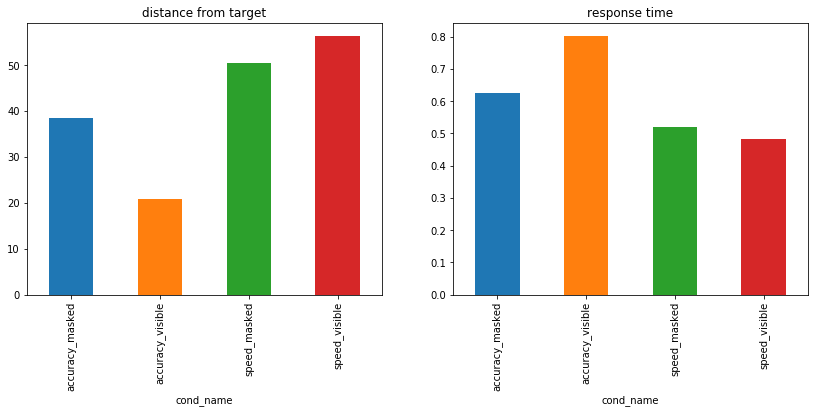

In [609]:
#Select how many units of precision to display in default printouts.
pd.set_option("display.precision", 6)

#Divide the data into groups based on Cue/Mask combination
df_groups = df.groupby('cond_name')

#Print the mean Accuracy and Response Time value of each condition group
print(df_groups[['acc','rt']].mean())

#Generate bar chart for Accuracy and Response Time calues by condition.
fig, axes = plt.subplots(1,2, figsize=(14,5))

axes[0].set_title("distance from target")
df_groups['acc'].mean().plot.bar(ax=axes[0])

axes[1].set_title("response time")
df_groups['rt'].mean().plot.bar(ax=axes[1])



## Identifying effects using regression

These effect sizes can be produced as coefficients on predictor variables, using a linear regression on the condition variable.

This is *substantially* less efficient, but will frequently be used from here on, because it enables the use of penalty terms to bias estimates in particular directions.

### Using Statsmodel

In [624]:
#Use the statsmodel package to find these coefficients, using R-style formula syntax.
rt_results = sm.ols(formula="rt ~ C(cond_name) -1", data=df).fit()

acc_results = sm.ols(formula="acc ~ C(cond_name) -1", data=df).fit()
print(rt_results.params,'\n',acc_results.params)


#note: the 'results' object has a 'summary' method which displays a more complete
#description of the regression results. Called using 'result.summary()'.

#These parameters are truncated for display. Print full precision parameters
#e.g., for identifying the mean to which we'll bias our regressions later
#print([x for x in rt_results.params])

C(cond_name)[accuracy_masked]     0.624731
C(cond_name)[accuracy_visible]    0.803058
C(cond_name)[speed_masked]        0.520597
C(cond_name)[speed_visible]       0.483530
dtype: float64 
 C(cond_name)[accuracy_masked]     38.475587
C(cond_name)[accuracy_visible]    20.894350
C(cond_name)[speed_masked]        50.473118
C(cond_name)[speed_visible]       56.409023
dtype: float64
[0.6247311508951408, 0.8030584648614477, 0.5205966167000955, 0.4835297753433103]


However, the OLS regression in statsmodel doesn't allow for custom loss functions— it appears that this can be done using customizations on their Generic Maximum Likelihood Estimate package, but for simplicity's sake, I'll be doing it using scipy.

### Hand-built regressions with Scipy

A handrolled regression functions can be built and optimized in scipy, which will more easily allow customization. There is some flexibility in the format of these functions.

### Four-Beta format

In [611]:

def generate_four_betas(params:(float), *args:(pd.DataFrame)) -> float:
    #this function accepts a data matrix (made of predictor matrix X and predictand vector y), and weight vector beta.
    #It returns a value indicating how closely beta*X matches y.
    
    data = args[0] #assign the matrix of predictor/predictand values.
    response_variable = args[1] #assign the desired response variable
    betas = pd.Series(params) #assign the weights being tested each optimization cycle
    squares = ((data[response_variable] - np.dot(data[[1,2,3,4]],betas))**2) #(y - beta*X)'*(y - beta*X)
    sum_of_squares = np.sum(squares) #sum the vector of squared errors.
    return sum_of_squares

#In scipy, run an optimization of the beta vector using BFGS.
params = optimize.fmin_bfgs(generate_four_betas, (0,0,0,0), disp=False, args=(df,'rt'))
print(params)

[0.52059661 0.62473114 0.48352977 0.80305846]


These values agree with those generated in Statsmodel to ~7 significant figures.

### Mask-toggle format

However, this doesn't match the format provided by Joachim, which is:

( y - ((1-z)(mu1+b1*x1) + (z)(mu+b2*x1)) )^2 = error_squared

The function can also be built manually.

In [616]:
def generate_mask_toggle_parameters(params:(float), *args:(pd.DataFrame)) -> float:
    
    #Define the variables to be used in the cost function. Note that x,y,z are vectors.
    data = args[0]
    response_variable = args[1]
    x = (data['cond_spdAcc'])
    y = data[response_variable]
    z = (data['cond_mask'])
    
    mu1, mu2, b1, b2 = params
    
    #Define the cost function
    squares = (y - ((1-z)*(mu1+b1*x) + (z)*(mu2+b2*x)))**2
    sum_of_squares = np.sum(squares)
    return sum_of_squares

params = optimize.fmin_bfgs(generate_mask_toggle_parameters, (0,0,0,0), disp=False, args=(df,'rt'))
print(params)

[0.52059661 0.48352977 0.10413453 0.31952869]


This format, which I'll call the 'mask-toggle format,' after the Z term's effect, is equivalent to what I'll call the  'four beta' format above, in that either can be used to produce the same response variable estimates.

As before, these same parameters can be found more quickly and efficiently using a simple statsmodel query as follows:

In [623]:
result = sm.ols(formula="rt ~ C(cond_mask) * C(cond_spdAcc) - 1", data=df).fit()
print(result.params)
#this code can give us our Beta Means for later:
#print([i for i in result.params])

C(cond_mask)[0]                          0.520597
C(cond_mask)[1]                          0.483530
C(cond_spdAcc)[T.1]                      0.104135
C(cond_mask)[T.1]:C(cond_spdAcc)[T.1]    0.215394
dtype: float64
[0.5205966167000978, 0.48352977534325725, 0.10413453419498693, 0.21539415532311978]


## Applying these functions session-wise

Any of these methods can now be used to produce regression coefficients on a per-session basis, where there are N ≈ 4700 sessions, each with ≤ 32 data points, depending on censoring.

This is done by dividing the dataframe into N groups defined by a unique combination of subject and block, and then looping the regression on each. Again, linear regression is a poor way to obtain these values, and is done only for consistency with later steps where a penalty term is introduced.

In [618]:
#create a 'groupby' object from the 'df' dataframe object, partitioned by subject and block.
df_sessions = df.groupby(['subj','blk'])

#a single session can be addressed and retrieved using e.g.,
#print(df_sessions.get_group((32,5)))

In [619]:


def run_optimization(function: Callable[[pd.DataFrame,str],int], groups:pd.core.groupby, variable: str) -> [np.ndarray]:
    #Loop a given regression function over every session in the given groupby object.
    #This is a very slow function, so a simple progress bar is included.
    session_groups = groups
    beta_list = []
    for count, (name, group) in enumerate(session_groups):
        paramlist = (optimize.fmin_bfgs(function, (0,0,0,0), disp=False, args=(group,variable)))
        beta_list.append(paramlist)
        
        #progress bar
        if count%470 == 0:
            print(".", end ="")
    print('\n')
    return beta_list

Now the parameter values can be generated.

In [620]:
four_betas_sessionwise = run_optimization(function=generate_four_betas, groups=df_sessions, variable="rt")
mask_toggle_params_sessionwise = run_optimization(function=generate_mask_toggle_parameters, groups=df_sessions, variable="rt")


*         *
*         *

These newly generated weights can be put into a pandas dataframe and plotted on a histogram.

In [621]:
#Create dataframes from the session-wise parameters
#One for four-betas, one for mask-toggle.
four_betas = pd.DataFrame(four_betas_sessionwise, columns=['b(masked speed cue)',
                                                         'b(masked acc cue)',
                                                         'b(viz speed cue)',
                                                         'b(viz acc cue)'])

mask_toggle_params = pd.DataFrame(mask_toggle_params_sessionwise, columns=['mu1(mask)',
                                                                         'mu2(viz)',
                                                                         'b1(mask)',
                                                                         'b2(viz)'])


In [661]:
#illustrate how our matrix of calculated weights looks.
print(mask_toggle_params.head(3))

   mu1(mask)  mu2(viz)  b1(mask)   b2(viz)
0   0.459092  0.409595  0.021275  0.259826
1   0.494309  0.491811  0.400939  0.253983
2   0.411215  0.415761  0.003811  0.227737


### Plotting sessionwise weights

We can now plot these values, for a graphical look at how the weights (in either format) are distributed.
Top: four-beta format
Bottom: Mask-toggle format (2 means, 2 betas)

Text(0.5,1,'Effect of Accuracy Cue by mask condition')

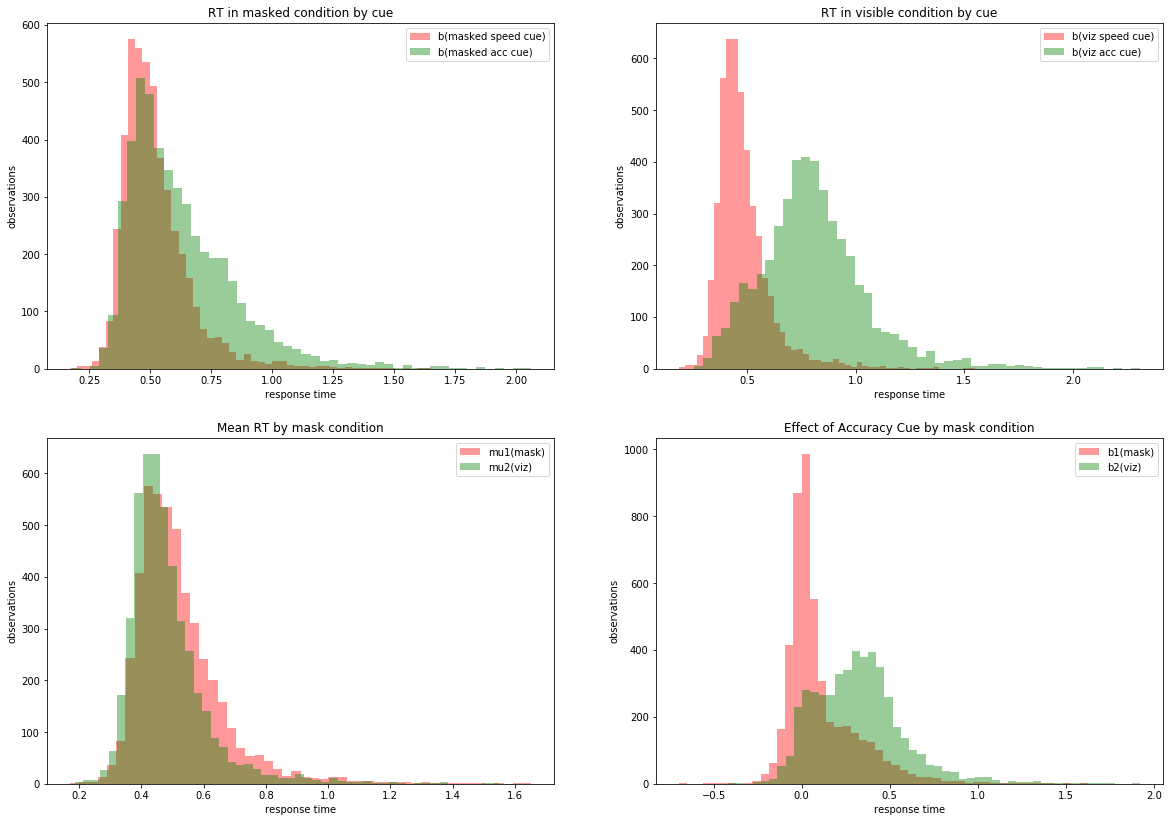

In [622]:
f, axes = plt.subplots(2, 2, figsize=(20,14), sharex=False)

sns.distplot( four_betas.iloc[:,0] , color="red", label=four_betas.columns[0], ax=axes[0,0], kde=False)
sns.distplot( four_betas.iloc[:,1] , color="green", label=four_betas.columns[1], ax=axes[0,0], kde=False).set(xlabel='response time', ylabel='observations')
axes[0,0].legend()
axes[0,0].set_title("RT in masked condition by cue")

sns.distplot( four_betas.iloc[:,2] , color="red", label=four_betas.columns[2], ax=axes[0,1], kde=False)
sns.distplot( four_betas.iloc[:,3] , color="green", label=four_betas.columns[3], ax=axes[0,1], kde=False).set(xlabel='response time', ylabel='observations')
axes[0,1].legend()
axes[0,1].set_title("RT in visible condition by cue")

sns.distplot( mask_toggle_params.iloc[:,0] , color="red", label=mask_toggle_params.columns[0], ax=axes[1,0], kde=False)
sns.distplot( mask_toggle_params.iloc[:,1] , color="green", label=mask_toggle_params.columns[1], ax=axes[1,0], kde=False).set(xlabel='response time', ylabel='observations')
axes[1,0].legend()
axes[1,0].set_title("Mean RT by mask condition")

sns.distplot( mask_toggle_params.iloc[:,2] , color="red", label=mask_toggle_params.columns[2], ax=axes[1,1], kde=False)
sns.distplot( mask_toggle_params.iloc[:,3] , color="green", label=mask_toggle_params.columns[3], ax=axes[1,1], kde=False).set(xlabel='response time', ylabel='observations')
axes[1,1].legend()
axes[1,1].set_title("Effect of Accuracy Cue by mask condition")




## Introducing the Penalty Term

Now these steps are repeated, using new loss functions with an additonal term that penalizes each session's weights for diverging from the grand mean of the weights.

For the mask-toggle function, this will be 
**(b1-b1_mean)^2 + (b2-b2_mean)^2**

and for the four-betas function, this will be
**np.sum(np.square(betas - beta_means)**

Of note, the four-beta version punishes all tested values for diverging from the grand mean, while the mask-toggle version only directly punishes the "beta" terms for diverging.

The mean values used were drawn from earlier stages in this analysis.

In [625]:
#define the new functions. They are equivalent except for the added penalty term.
def generate_mask_toggle_parameters_biased(params, *args):
    
    #Define the variables to be used in the cost function. Note that x,y,z are vectors.
    data = args[0]
    response_variable = args[1]
    x = (data['cond_spdAcc'])
    y = data[response_variable]
    z = (data['cond_mask'])
    
    mu1, mu2, b1, b2 = params
    
    #Define the measured mean values for beta1 and beta2
    b1_mean = 0.10413453419
    b2_mean = 0.31952868951
    
    #Function below with added penalty term.
    squares = ((y - ((1-z)*(mu1+b1*x) + (z)*(mu2+b2*x)))**2 + ((b1-b1_mean)**2 + (b2-b2_mean)**2))
    sum_of_squares = np.sum(squares)
    return sum_of_squares

def generate_four_betas_biased(params:(float), *args:(pd.DataFrame)) -> float:
    data = args[0]
    response_variable = args[1]
    betas = pd.Series(params)  
    
    #Define the measured mean values for betas 1,2,3,4.
    beta_means = pd.Series([0.5205966167000955, 0.6247311508951408, 0.4835297753433103, 0.8030584648614477])
    
    #Introduce penalty term.
    squares = ((data[response_variable] - np.dot(data[[1,2,3,4]],betas))**2 + np.sum(np.square(betas - beta_means)))
    sum_of_squares = np.sum(squares)
    return sum_of_squares

In [626]:
#Run the new, biased functions on the Response Time data.
four_betas_sessionwise_biased = run_optimization(function=generate_four_betas_biased, groups=df_sessions, variable="rt")
mask_toggle_params_sessionwise_biased = run_optimization(function=generate_mask_toggle_parameters_biased, groups=df_sessions, variable="rt")


*         *
*         *

Now the biased values can be plotted against the unbiased values.

In [627]:
four_betas_biased = pd.DataFrame(four_betas_sessionwise_biased, columns=['b(masked speed cue)(biased)',
                                                         'b(masked acc cue)(biased)',
                                                         'b(viz speed cue)(biased)',
                                                         'b(viz acc cue)(biased)'])

mask_toggle_params_biased = pd.DataFrame(mask_toggle_params_sessionwise_biased, columns=['mu1(mask)(biased)',
                                                                         'mu2(viz)(biased)',
                                                                         'b1(mask)(biased)',
                                                                         'b2(viz)(biased)'])


### Plotting biased outputs against standard outputs.

Again, four-beta is on top, mask-toggle is on bottom.

Note: bin width is not uniform, causing biased values to appear less populous. However, the count is identical.

Text(0.5,1,'Effect of Accuracy Cue by mask condition')

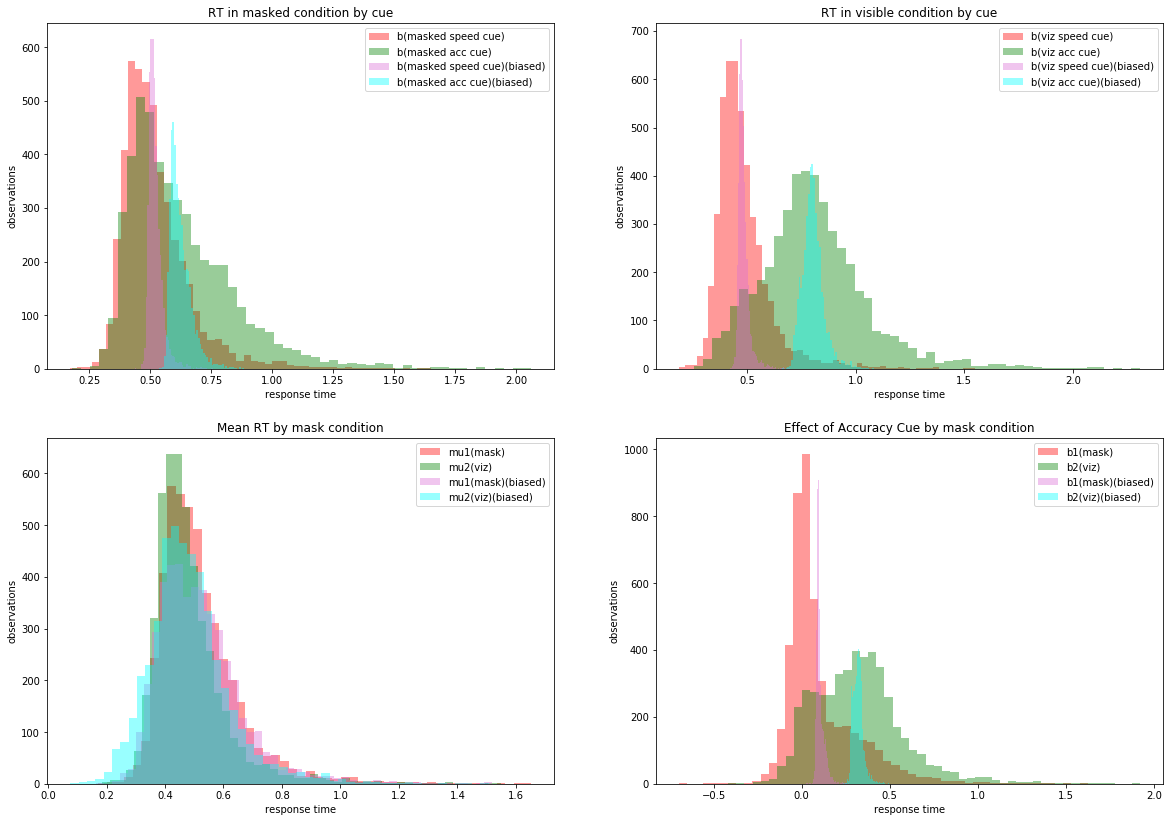

In [628]:
f, axes = plt.subplots(2, 2, figsize=(20,14), sharex=False)

sns.distplot( four_betas.iloc[:,0] , color="red", label=four_betas.columns[0], ax=axes[0,0], kde=False)
sns.distplot( four_betas.iloc[:,1] , color="green", label=four_betas.columns[1], ax=axes[0,0], kde=False).set(xlabel='response time', ylabel='observations')
axes[0,0].legend()
axes[0,0].set_title("RT in masked condition by cue")

sns.distplot( four_betas.iloc[:,2] , color="red", label=four_betas.columns[2], ax=axes[0,1], kde=False)
sns.distplot( four_betas.iloc[:,3] , color="green", label=four_betas.columns[3], ax=axes[0,1], kde=False).set(xlabel='response time', ylabel='observations')
axes[0,1].legend()
axes[0,1].set_title("RT in visible condition by cue")

sns.distplot( mask_toggle_params.iloc[:,0] , color="red", label=mask_toggle_params.columns[0], ax=axes[1,0], kde=False)
sns.distplot( mask_toggle_params.iloc[:,1] , color="green", label=mask_toggle_params.columns[1], ax=axes[1,0], kde=False).set(xlabel='response time', ylabel='observations')
axes[1,0].legend()
axes[1,0].set_title("Mean RT by mask condition")

sns.distplot( mask_toggle_params.iloc[:,2] , color="red", label=mask_toggle_params.columns[2], ax=axes[1,1], kde=False)
sns.distplot( mask_toggle_params.iloc[:,3] , color="green", label=mask_toggle_params.columns[3], ax=axes[1,1], kde=False).set(xlabel='response time', ylabel='observations')
axes[1,1].legend()
axes[1,1].set_title("Effect of Accuracy Cue by mask condition")

#now the biased values are plotted over the top.
sns.distplot( four_betas_biased.iloc[:,0] , color="orchid", label=four_betas_biased.columns[0], ax=axes[0,0], kde=False)
sns.distplot( four_betas_biased.iloc[:,1] , color="cyan", label=four_betas_biased.columns[1], ax=axes[0,0], kde=False).set(xlabel='response time', ylabel='observations')
axes[0,0].legend()
axes[0,0].set_title("RT in masked condition by cue")

sns.distplot( four_betas_biased.iloc[:,2] , color="orchid", label=four_betas_biased.columns[2], ax=axes[0,1], kde=False)
sns.distplot( four_betas_biased.iloc[:,3] , color="cyan", label=four_betas_biased.columns[3], ax=axes[0,1], kde=False).set(xlabel='response time', ylabel='observations')
axes[0,1].legend()
axes[0,1].set_title("RT in visible condition by cue")

sns.distplot( mask_toggle_params_biased.iloc[:,0] , color="orchid", label=mask_toggle_params_biased.columns[0], ax=axes[1,0], kde=False)
sns.distplot( mask_toggle_params_biased.iloc[:,1] , color="cyan", label=mask_toggle_params_biased.columns[1], ax=axes[1,0], kde=False).set(xlabel='response time', ylabel='observations')
axes[1,0].legend()
axes[1,0].set_title("Mean RT by mask condition")

sns.distplot( mask_toggle_params_biased.iloc[:,2] , color="orchid", label=mask_toggle_params_biased.columns[2], ax=axes[1,1], kde=False)
sns.distplot( mask_toggle_params_biased.iloc[:,3] , color="cyan", label=mask_toggle_params_biased.columns[3], ax=axes[1,1], kde=False).set(xlabel='response time', ylabel='observations')
axes[1,1].legend()
axes[1,1].set_title("Effect of Accuracy Cue by mask condition")



# A vastly more efficient alternative

All of this is extremely inefficient.

There are some major shortcuts we can take, illustrated in the four-beta format.

In particular, we can 
1. calculate the main effect of each condition precisely as the condition's response variable mean.
2. subtract this main effect from all response variable values, *forcing* the grand mean beta value for all sessions to approximately 0.
3. With a grand mean value of 0, we are simply penalizing scores according to the magnitude of the beta vector— which is just l2 regularization, a 'ridge regression.'

The computational simplicity of and well-designed algorithms for ridge regression make the entire process many times faster, allowing us to test many different *tuning parameters* on the penalty term, which can often be desirable.

### Generating the data


In [629]:
#Calculate the condition means.
condition_means = df.groupby('cond')[['acc','rt']].mean()

#Create a series out of the rt column.
rt_means = condition_means.loc[:,'rt']

In [635]:
#Subtract condition means, conditionwise, from the response variable.
df_dm = df.copy()

#subtract the grand average condition effect from each response variable observation.
for condition in range(1,5):
    #create 'mask', a series of booleans, to serve as selectors for next operation 
    mask = df_dm[condition] == 1 
    #on rows where mask == True, apply .subtract operation.
    df_dm.loc[mask, 'rt'] = df_dm.loc[mask, 'rt'].subtract(rt_means[condition])

In [637]:
#illustrate that grand mean betas are very close to 0
result = sm.ols(formula="rt ~ C(cond) -1", data=df_dm).fit()
print([i for i in result.params])

[8.326672684688674e-17, 1.510944147575799e-15, -3.127652217077559e-16, 4.0245584642661925e-16]


In [639]:
#Group de-meaned data by session
df_dm_sessions = df_dm.groupby(['subj','blk'])

In [652]:
# Define our new regression functions, making use of statsmodel's very efficient code.

def easy_fit_ols(data_groups, column):
    #run each group in the passed groupby object through the statsmodel regression.
    easy_betas = []
    for index, (name, group) in enumerate(data_groups):
        result = sm.ols(formula=f"{column} ~ C(cond) -1", data=group).fit()
        
        easy_betas.append([i for i in result.params])
        
        #progress bar
        if index%470 == 0:
            print('.', end = '')
    print('\n')
    return easy_betas

def easy_fit_l2(dataframe, column, tuning):
    #same as easy_fit_ols, but includes l2 regularization, whose penalty is weighted according to the 'tuning' parameter
    easy_betas = []
    for index, (name, group) in enumerate(dataframe):
    
        result = sm.ols(formula=f"{column} ~ C(cond) -1", data=group).fit_regularized(method='elastic_net', alpha=tuning, L1_wt=0.0, start_params=None, profile_scale=False, refit=False)
        
        easy_betas.append([i for i in result.params])

        if index%470 == 0:
            print('.', end = '')
    print('\n')
    return easy_betas

In [653]:
#Populate dataframes using the 'easy_fit' data generation functions.

easy_betas = pd.DataFrame(easy_fit_ols(df_dm_sessions, 'rt'), columns=['b(masked speed cue)',
                                                         'b(masked acc cue)',
                                                         'b(viz speed cue)',
                                                         'b(viz acc cue)'])

easy_betas_biased = pd.DataFrame(easy_fit_l2(df_dm_sessions, 'rt', tuning=1), columns=['b(masked speed cue)(biased)',
                                                         'b(masked acc cue)(biased)',
                                                         'b(viz speed cue)(biased)',
                                                         'b(viz acc cue)(biased)'])


...........

...........



In [654]:
#Restore the subtracted main effect to each session beta weight.
for i in range(4):
    easy_betas.iloc[:,i] += rt_means[i+1]
    easy_betas_biased.iloc[:,i] += rt_means[i+1]


### Illustrating equivalence

The values produced in this manner agree to 5 decimal places.

In [665]:
diff_reg = four_betas - easy_betas
print(diff.max())

diff_biased = four_betas_biased - easy_betas_biased
print(diff_biased.max())

b(masked speed cue)    2.740457e-06
b(masked acc cue)      6.134636e-07
b(viz speed cue)       5.917510e-07
b(viz acc cue)         9.156930e-07
dtype: float64
b(masked speed cue)(biased)    3.092115e-07
b(masked acc cue)(biased)      1.600688e-07
b(viz speed cue)(biased)       1.679416e-07
b(viz acc cue)(biased)         1.941758e-07
dtype: float64


### Graphic result

Text(0.5,1,'RT in visible condition by cue')

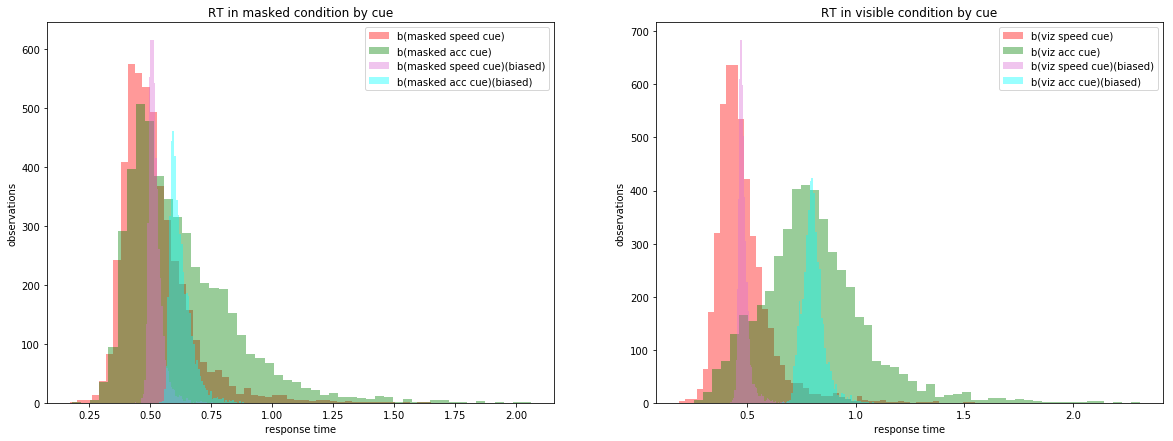

In [659]:
bincount = 50
f, axes = plt.subplots(1, 2, figsize=(20,7), sharex=False)

sns.distplot( easy_betas.iloc[:,0] , color="red", label=easy_betas.columns[0], ax=axes[0], kde=False, bins=bincount)
sns.distplot( easy_betas.iloc[:,1] , color="green", label=easy_betas.columns[1], ax=axes[0], kde=False, bins=bincount).set(xlabel='response time', ylabel='observations')
axes[0].legend()
axes[0].set_title("RT in masked condition by cue")

sns.distplot( easy_betas.iloc[:,2] , color="red", label=easy_betas.columns[2], ax=axes[1], kde=False, bins=bincount)
sns.distplot( easy_betas.iloc[:,3] , color="green", label=easy_betas.columns[3], ax=axes[1], kde=False, bins=bincount).set(xlabel='response time', ylabel='observations')
axes[1].legend()
axes[1].set_title("RT in visible condition by cue")


#now the biased values are plotted over the top.
sns.distplot( easy_betas_biased.iloc[:,0] , color="orchid", label=easy_betas_biased.columns[0], ax=axes[0], kde=False, bins=bincount)
sns.distplot( easy_betas_biased.iloc[:,1] , color="cyan", label=easy_betas_biased.columns[1], ax=axes[0], kde=False, bins=bincount).set(xlabel='response time', ylabel='observations')
axes[0].legend()
axes[0].set_title("RT in masked condition by cue")

sns.distplot( easy_betas_biased.iloc[:,2] , color="orchid", label=easy_betas_biased.columns[2], ax=axes[1], kde=False, bins=bincount)
sns.distplot( easy_betas_biased.iloc[:,3] , color="cyan", label=easy_betas_biased.columns[3], ax=axes[1], kde=False, bins=bincount).set(xlabel='response time', ylabel='observations')
axes[1].legend()
axes[1].set_title("RT in visible condition by cue")

